In [2]:
!pip install pandas xgboost catboost lightgbm tabPFN imbalanced-learn


### 1: 
Importing the libraries:

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tabpfn import TabPFNClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV, LassoCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

### 2:
load the data and declaring the dataframe and split the data to matrix X and vector Y (I'll do it later as a part of step 3)

A dataset for classification task the output is the income column.
32561 rows, 15 cols 6 numerical features.
 you can find the dataset here: https://www.kaggle.com/datasets/uciml/adult-census-income

In [4]:
df = pd.read_csv('adult.csv')
print(df.shape)
print(df.dtypes)

(32561, 15)
age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object


### 3:
Creating a preprocessing function:
* I decided to create sub functions first and call them from a 'main' function.

A:  CHECKING FOR MISSING VALUES (THERE ISN'T MISSING VALUES) AND CATEGORICAL COLS

In [5]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [6]:
def check_missing_values(df):
    print("Checking for missing values:")
    print(df.isnull().sum())
    # df = df.fillna()  THERE IS NO NULL VALUES ANYWAY SO WE DON'T NEED THAT (:
    return df

def drop_high_cardinality_categorical_features(X, threshold=5):
    categorical_cols = X.select_dtypes(include='object').columns
    high_card_cols = [col for col in categorical_cols if X[col].nunique() > threshold]
    
    print(f"🧹 Dropping high-cardinality categorical columns: {high_card_cols}")
    X = X.drop(columns=high_card_cols)
    
    return X

def convert_categorical_to_dummies(X):
    print("Converting categorical variables to dummy variables...")
    X = pd.get_dummies(X, drop_first=True) 
    print(f"New shape after encoding: {X.shape}")
    return X


B: REMOVING DUPLICATES:

In [7]:
def remove_duplicate_rows(X, y):
    print("Initial number of rows:", len(X))
    
    # Combine X and y to detect and drop duplicates together
    df_combined = pd.concat([X, y], axis=1)
    df_combined_no_duplicates = df_combined.drop_duplicates()

    # Separate X and y again
    X_cleaned = df_combined_no_duplicates.drop(columns=[y.name])
    y_cleaned = df_combined_no_duplicates[y.name]

    print("Number of rows after removing duplicates:", len(X_cleaned))
    return X_cleaned, y_cleaned


C: SPLITTING FOR TRAIN/TEST:

In [8]:
def split_data(X, y, test_size=0.2, random_state=42):
    print("Splitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    print(f"Training set size: {X_train.shape}")
    print(f"Testing set size: {X_test.shape}")
    return X_train, X_test, y_train, y_test

D: STANDARDIZE THE DATA:

In [9]:
def standardize_features(X_train, X_test):
    print("Standardizing feature columns...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Standardization complete.")
    return X_train_scaled, X_test_scaled

E: Handle Class Imbalance:
I used Chat GPT in this part for helping me plotting the graph
* There was a need to balance the data and I chose to oversampling the minority class because it's simple and avoids losing data.
* The advantages of this method are: preventing the model from being biased toward the majority class, improving recall and F1-score for the minority class, and it works well on decision tree and random forest which I will use later in this project.
* We use this method when the dataset is small, when we want to avoid losing information, and when the minority class have high importance for the model.

In [10]:
def analyze_class_imbalance(y):
    print("Class distribution:")
    print(y.value_counts())
    print("\nPercentage distribution:")
    print(round(y.value_counts(normalize=True) * 100, 2))
    
    # Plot class distribution
    plt.figure(figsize=(6, 4))
    y.value_counts().plot(kind='bar', color='skyblue')
    plt.title('Target Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


F: MAKE THE FUNCTION CALLS BY THE ORDER

In [ ]:
def main_classification_pipeline(df, target_column):
    # Step 1: Split to X and y
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Step 2: Handle missing values in X
    X = check_missing_values(X)

    # Step 3: Remove high-cardinality categorical columns from X
    X = drop_high_cardinality_categorical_features(X)

    # Step 4: Convert categorical columns in X to dummy variables
    X = convert_categorical_to_dummies(X)

    # Step 5: Remove duplicate rows from X and y 
    X, y = remove_duplicate_rows(X, y)

    # Step 6: Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Step 7: Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Step 8: Analyze class imbalance
    analyze_class_imbalance(y) 

    # Step 9: Imbalance detected: Oversample the minority class in the training set and stardize again
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Step 10: Report final class distribution
    print("\nFinal class distribution in training set:")
    print(y_train.value_counts(normalize=True) * 100)

    return X_train_scaled, X_test_scaled, y_train, y_test

Checking for missing values:
age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
dtype: int64
🧹 Dropping high-cardinality categorical columns: ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'native.country']
Converting categorical variables to dummy variables...
New shape after encoding: (32561, 11)
Initial number of rows: 32561
Number of rows after removing duplicates: 32376
Class distribution:
income
<=50K    24553
>50K      7823
Name: count, dtype: int64

Percentage distribution:
income
<=50K    75.84
>50K     24.16
Name: proportion, dtype: float64


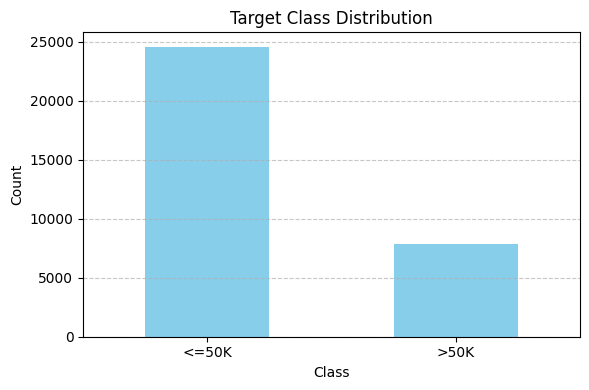


Final class distribution in training set:
income
>50K     50.0
<=50K    50.0
Name: proportion, dtype: float64


In [12]:
X_train_scaled, X_test_scaled, y_train, y_test = main_classification_pipeline(df, target_column='income')

### 4:
Train classification models:

In [13]:
print(y_train.dtype)
print(y_train.unique())

# Needed because the target variable is an object type.
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test) 
print(y_train.dtype)
print(y_test.dtype)


object
['>50K' '<=50K']
int32
int32


XGBoost:

In [ ]:
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 8, None]
}

xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train)

best_xgb_model = xgb_grid.best_estimator_
print("Best XGBoost Parameters:", xgb_grid.best_params_)


Random Forest:

In [ ]:
rf_model = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None]
}

rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)

best_rf_model = rf_grid.best_estimator_
print("Best Random Forest Parameters:", rf_grid.best_params_)


NameError: name 'RandomForestClassifier' is not defined

Catboost:

In [ ]:
cat_model = CatBoostClassifier(verbose=0)
cat_param_grid = {
    'depth': [6, 10, 12],
    'learning_rate': [0.01, 0.1]
}

cat_grid = GridSearchCV(cat_model, cat_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
cat_grid.fit(X_train_scaled, y_train)

best_cat_model = cat_grid.best_estimator_
print("Best CatBoost Parameters:", cat_grid.best_params_)


LGBM:

In [ ]:
lgbm_model = LGBMClassifier()
lgbm_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1]
}

lgbm_grid = GridSearchCV(lgbm_model, lgbm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
lgbm_grid.fit(X_train_scaled, y_train)

best_lgbm_model = lgbm_grid.best_estimator_
print("Best LightGBM Parameters:", lgbm_grid.best_params_)


TabPFN:

In [ ]:
tabpfn_model = TabPFNClassifier(device='cuda' if torch.cuda.is_available() else 'cpu',ignore_pretraining_limits=True)

# Fit on the smaller training set
tabpfn_model.fit(X_train_scaled, y_train)


BernouliRBM which we didn't learn in class.
* I used this documentation: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.BernoulliRBM.html

In [ ]:
# Define preprocessing + RBM + LogisticRegression pipeline
rbm_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),  # Optional but recommended
    ('rbm', BernoulliRBM(random_state=42)),
    ('log_reg', LogisticRegression(max_iter=1000))
])

rbm_params = {
    'rbm__n_components': [32, 64],
    'log_reg__C': [0.1, 1.0]
}

# Create and run GridSearchCV
rbm_grid = GridSearchCV(rbm_pipeline, rbm_params, cv=5, scoring='accuracy', n_jobs=-1)
rbm_grid.fit(X_train_scaled, y_train)

# Best model and parameters
best_rbm_model = rbm_grid.best_estimator_
print("Best RBM + Logistic Regression Parameters:", rbm_grid.best_params_)

### 5:
Building a NN model


I built a 3-layer feedforward NN with the following structure:
* Dense layer - 64 neurons - with ReLu activation function - BatchNormalization (https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) for faster convergence - and Dropout(0.3).
* Dense - 32 neurons - ReLU - Dropout(0.2)
* Dense - 1 neuron + Sigmoid (for 2-class classification ('income'))
I chose this architecture in order to prevent overfitting using dropout and earlystopping, speed-up training using BatchNormalization, Ensure non linearity with ReLu.

Related to my data I chose this architecture because my data is medium size and this architecture made the model optimized for binary classification and the feature space is not high dimensional after 'clean_categorical_columns' method so i try a simple and shallow version for now.

In [ ]:
model = Sequential([
    Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    BatchNormalization(trainable = False),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # For binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

### 6: 
Making Predictions:

A: Making Predicitons on the models I created before on train set and test set and print the classification report.

In [ ]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test, is_nn=False):
    print(f"\n📌 {name} – Train Performance:")
    y_train_pred = (model.predict(X_train) > 0.5).astype(int).flatten() if is_nn else model.predict(X_train) # CAN'T PRINT CLASSIFICATION REPORT ON CONTINOUS NUMBERS IN NN
    print(classification_report(y_train, y_train_pred))

    print(f"📌 {name} – Test Performance:")
    y_test_pred = (model.predict(X_test) > 0.5).astype(int).flatten() if is_nn else model.predict(X_test)
    print(classification_report(y_test, y_test_pred))


In [ ]:
evaluate_model("XGBoost", best_xgb_model, X_train_scaled, y_train, X_test_scaled, y_test)

In [ ]:
evaluate_model("Random Forest", best_rf_model, X_train_scaled, y_train, X_test_scaled, y_test)

In [ ]:
evaluate_model("Catboost", best_cat_model, X_train_scaled, y_train, X_test_scaled, y_test)

In [ ]:
evaluate_model("LightGBM", best_lgbm_model, X_train_scaled, y_train, X_test_scaled, y_test)

Due to computational limitations, TabPFN was evaluated on a 1000-sample subset. While this doesn't allow a fully fair comparison, it offers insight into TabPFN's performance characteristics on limited data.

In [ ]:
X_train_small = X_train_scaled[:1000]
y_train_small = y_train[:1000]

X_test_small = X_test_scaled[:1000]
y_test_small = y_test[:1000]

evaluate_model("TabPFN", tabpfn_model, X_train_small, y_train_small, X_test_small, y_test_small)

But I ran the evaluate_model in VS code on the original data (X_train_scaled, y_train, X_test_scaled, y_test) and I markdown the results to be consistent with answer 6.B + 6.C

In [ ]:
#evaluate_model("TabPFN", tabpfn_model, X_train_scaled, y_train, X_test_scaled, y_test)

In [ ]:
evaluate_model("BernouliRBM", best_rbm_model, X_train_scaled, y_train, X_test_scaled, y_test)

In [ ]:
evaluate_model("NN model", model, X_train_scaled, y_train, X_test_scaled, y_test,is_nn=True)

B: Based on accuracy explain who is the best model, regard to train/test prediction, and use overfitting-underfitting terms:
* Based on the accuracy metric, the best-performing model is the Neural network, which achieved 81% accuracy on the test set and 77% on the training set. The relatively small gap between the two sets suggests that the model does not suffer from overfitting or underfitting. Instead, it demonstrates good generalization closing to appropriate fit.

C: Based on other metric explain who is the best model, regard to train/test prediction, explain the meaning of the metric and why does it relevant to this prediction task:
* When considering the F1-score for class 1, the CatBoost model demonstrates the best performance, achieving an F1-score of 0.87 on the training set and 0.65 on the test set. The F1-score is the harmonic mean of precision and recall, and is especially valuable in classification tasks involving imbalanced datasets — like in our case, where the minority class (>50K) represents only about 24% of the data. 
if we wrongly predict a user as being the highest income group when he's not, it could lead to unfair decisions like offering services they don't qualify for.

### 7:
A: Improving the NN:

In [ ]:
model_improved = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],), activation='tanh'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='tanh'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(32, activation='tanh'),

    Dense(1, activation='sigmoid')
])

model_improved.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_improved.summary()

In [ ]:
history_improved = model_improved.fit( 
    X_train_scaled, y_train,
    validation_split=0.3,
    epochs=30,
    batch_size=32,
    verbose=1
)

Showing the differences:

In [ ]:
evaluate_model("Neural Network", model, X_train_scaled, y_train, X_test_scaled, y_test,is_nn = True)
evaluate_model("Enhanced Neural Network", model_improved, X_train_scaled, y_train, X_test_scaled, y_test,is_nn = True)

7.b:

The original neural network already showed good performance, but several changes were made to improve generalization. The activation function was switched to tanh for smoother convergence, and the number of neurons and layers was increased to capture more complex patterns. Batch normalization was added for stability, dropout was reduced since overfitting wasn’t an issue, and the validation split was increased for better performance monitoring.  These modifications were aimed at pushing an already strong model to perform even better as reflected by the improved evaluation metrics.